In [71]:
# Specify Lib
import numpy as np
from numpy import array
from numpy.random import choice 
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import integrate
from scipy.stats import norm
import scipy.stats as stats

In [72]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif", 
    "font.serif" : "cm"
})

In [73]:
# Units 
c=299792458 #SI
G=6.674e-11 #SI
SolM=1.9891e30 #Solar mass SI
unit=SolM*G/(c**3) #Conversion of mass to seconds

In [74]:
##Load the data from the output of class
data_orin = np.loadtxt( "/Users/richard/Documents/class_public-master/output/lcdm01_background.dat" )
## Determine the range of redhsift we are interested in
zmin=0.01
zmax=6
NoGW=200

z_step=4000  ##Higher steps, means more accurate simulations, but slower code 2000 works well 

## Pull the data from the output of class code:
z=data_orin[:,0] ## redshift
t=data_orin[:,1] ##proper time in terms of Gyrs
d_l=data_orin[:,6] ## luminosity distance in Mpc
d_l=d_l*(3.08567758149137e22)/c       ##convert to seconds [Mpc]/[c]
d_c=data_orin[:,5] ## comoving distance 
d_c=d_c*(3.08567758149137e22)/c       ##convert to seconds [Mpc]/[c]
H=data_orin[:,3]  ## hubble constant
H=H*c/(3.08567758149137e22)           ##convert 1/s        [c]/[Mpc]

In [75]:
## We then interpolate the data we have picked as the implicit funtion is unkown
fH=interpolate.interp1d(z,H, kind='cubic')
fd_c=interpolate.interp1d(z,d_c, kind='cubic')
fd_l=interpolate.interp1d(z,d_l, kind='cubic')
ft=interpolate.interp1d(z,t, kind='cubic')


## We can then chose the redshift range we are interested in
## from this we create new data from the interpolation in the redshift range
Z=np.linspace(zmax,zmin,z_step).reshape(-1,1)
#Z=np.random.uniform(zmin,zmax,z_step).reshape(-1,1)

H_new=fH(Z)
d_c_new=fd_c(Z)
d_l_new=fd_l(Z)
t_new=ft(Z)

## Create a temporary array to hold the new interpolated data
D=[]
D=np.concatenate((Z, H_new, d_c_new, d_l_new, t_new),axis=1)

In [76]:
i=0
R=[]
while i<= z_step-1:
    a=Z[i,0]
    if a<=1:
        r=1+2*a
    elif 1<a<=5:
        r=3*(5-a)/4
    else: r=0
    R.append(r)
    i=i+1
R=array([R],dtype=np.float32).T    
P=4*np.pi*(d_c_new**2)*R/(H_new*(1+Z))
P_dist=P/sum(P)

In [77]:
data=[]
def simulation(NoGW,data):
    
    ## We can then pick our sources of redshift weighted by the distribution 
    Z_new=choice(Z[:,0],p=P_dist[:,0],size=NoGW)
    
    ## At this point we now have 1000 simulated redshifts sources. 
    ## We then pick out the corresponding interpolated data, to be our simulation
    data=[]
    i=0
    while i<NoGW:
        d=D[D[:,0]==(Z_new[i])]
        data=np.concatenate((data,d[:,0],d[:,1],d[:,2],d[:,3],d[:,4]),axis=0)
        i=i+1
    
    ## All the units are the same as the output from class
    data=np.array(data).reshape((NoGW,5)) ## This now holds our simulated data
    ## c.1=z c.2=H c.3=comov dist c.4=lum dist c.5=time 
    
    
    
    
    ##############################################################################
    ###             SECTION 3 - ADDITIONAL SIMULATED DATA (Without the need for distribution)
    
    
    ## At this point I add other simulated measurements - but these do not need
    ## A distribution, they can be random or called upon from sources in arXiv
    
    ## Add in additional columns to the data to provide 
    ## theta, phi: relative location of the source in the sky and psi: polarisation angle
    
    ##Here I have used a random generator to provide locations and polarisation
    theta=np.random.rand(data[:,1].size,1)*2*np.pi 
    phi=np.random.rand(data[:,1].size,1)*np.pi
    psi=np.random.rand(data[:,1].size,1)*np.pi
    
    data=np.concatenate((data,theta,phi,psi),axis=1)
    ## c.1=z c.2=H c.3=comov dist c.4=lum dist c.5=t c.6=theta c.7=phi c.8=psi 
    
    
    ## Add in additional column to the data for the angle of binary orbital angular momentum, l
    ## Again here I have used a random generator between 0-20 degrees, as per constraint 
    l=np.random.rand(data[:,1].size,1)*20*np.pi/180
    
    data=np.append(data,l,axis=1)
    ## c.1=z c.2=H c.3=comov dist c.4=lum dist c.5=t c.6=theta c.7=phi c.8=psi c.9=l
    
    
    ## Add in additional column of the masses, m1 and m2, of the binary system 
    ## Then compute the total mass, M_tot, symmetric mass ratio, M_sym, and chrip mass, M_c.
    ## All masses are in units of solar mass 
    
    
    ## m_NS: Minimum is 1.17 from arXiv: 1808.02328 Max is 2.9 from arXiv: astro-ph/9608059 
    ## m_BH: maxiumum currently used value from arXiv: 1608.08008
    
    m1=np.random.randint(117,290,size=(data[:,1].size,1))/100
    ## Ratio of BHNS and BNS systems is 0.03 from LIGO, used for our simulation  
    ratio=int(data[:,1].size*0.03)       #forcing integer values so all arrays align
    
    m2_ns=np.random.randint(117,290,size=(data[:,1].size-ratio,1))/100
    m2_bh=np.random.randint(291,1000,size=(ratio,1))/100
    m2=(np.concatenate((m2_ns,m2_bh),axis=0)) 
    np.random.shuffle(m2)  ##Shuffle the masses throughout the redshift
    
    M_tot=m1+m2 ##total mass
    M_c=(1+data[:,0,None])*M_tot[:,0,None]*( (((m1[:,0,None]*m2[:,0,None])/M_tot[:,0,None]**2)) **(3/5)) * unit  ##Chirp mass converted to units of seconds
    print(M_c.shape)
    
    ##############################################################################
    ###             SECTION 3 - SIMULATING THE ERRORS
    
    """
    
    We have two errors to simulate here
    1. The error due to the distance of the GW
    2. The error from the instruments, in this case from the Einstein Telescope, ET. 
    """
    
    
    
    ## Antenna pattern functions observed by ET arXiv:1608.0800
    ## plus, cross are the orientations seen 1,2,3 are the inferometers used 
    def plus(theta,phi,psi):
        return np.sqrt(3)*( 0.5*(1+np.cos(theta)**2) * np.cos(2*phi)*np.cos(2*psi) - np.cos(theta)*np.sin(2*phi)*np.sin(2*psi)) /2 
    def cross(theta,phi,psi):
        return np.sqrt(3)*( 0.5*(1+np.cos(theta)**2) * np.cos(2*phi)*np.cos(2*psi) + np.cos(theta)*np.sin(2*phi)*np.sin(2*psi)) /2 
    F1plus=plus(theta,phi,psi)
    F1cross=cross(theta,phi,psi)
    F2plus=plus(theta,phi+2*np.pi/3,phi)
    F2cross=cross(theta,phi+2*np.pi/3,phi)
    F3plus=plus(theta,phi+4*np.pi/3,phi)
    F3cross=cross(theta,phi+4*np.pi/3,phi)
        
    
    ### Define a funtion to compute the signal to noise ratio, SNR, for any inferometer
    
    def SNR(Fplus,Fcross):
        i=0
        snr=[]
        while i<=data[:,1].size-1:  ## Go through all of the simulated redshifts
            
        
            ##Overal phase of FT based on arXiv: 0903.0338
            #gamma=0.5772156649  #Euler's constant
            
        
            
        
            ## FT of strain/relative distance moved
            Amp=np.sqrt((Fplus[i,0]*(1+np.cos(l[i,0])**2))**2 + (2*Fcross[i,0]*np.cos(l[i,0]))**2) * np.sqrt(5*np.pi/96) * np.pi**(-7/6) * M_c[i,0]**(5/6)/data[i,3]
            if np.isnan(Amp)==True:
                Amp=np.sqrt(-((Fplus[i,0]*(1+np.cos(l[i,0])**2))**2 + (2*Fcross[i,0]*np.cos(l[i,0]))**2)) * np.sqrt(5*np.pi/96) * np.pi**(-7/6) * M_c[i,0]**(5/6)/data[i,3]
                Amp=Amp*1j
                

               
            def PSD(f):   ## One sided power spectral density arXiv: 1009.0206
                f0=(200)
                x=(f)/f0
                S0=(1.449*1e-52)
                p1=(-4.05)
                p2=(-0.69)
                a1=(185.62)
                a2=(232.56)
                b1=(31.18)
                b2=(-64.72)
                b3=(52.24)
                b4=(-42.16)
                b5=(10.17)
                b6=(11.53)
                c1=(13.58)
                c2=(-36.46)
                c3=(18.56)
                c4=(27.43 ) 
                return (S0*(x**(p1) + a1*x**(p2) 
                       +a2*( (1+ b1*x + b2*x**2 + b3*x**3 + b4*x**4 + b5*x**5 +b6*x**6) / (1+ c1*x + c2*x**2 + c3*x**3 +c4*x**4) )  ))
        
            ## Here we state the bounds of frequency that ET can measure
            f_lower=1 ##current lowest detection 
            f_upper=((c**3)/(6**(3/2)*np.pi*G*(1+data[i,0])*M_tot[i,0]*SolM)) ##current higest detection from the last stable orbit freq
        
            
            ## Finally to compute the signal to noise ratio we need to compute 
            ## The intergral shown below and in arXiv: 1009.0206
            ## Simplified intergrand  - due to exp vanishing
            def Integrand(f):
                return( ((f**(-7/3)) * (np.absolute(Amp))**2 ) / PSD(f))
            
            
            I=4*integrate.quad(Integrand,f_lower,f_upper)
            snr.append((I))
            i=i+1  ## Close the while loop and start on the next simulated redshift
            
        snr=array(snr) ## Create an array of the SNR for each simulated redshift
        
        ## Combine the integral error with the integral to provide full SNR error
        snr=snr[:,0,None]+snr[:,1,None]
        return snr
    ##############################################################################
       
    ## At this point we are now ready to use our defined SNR function to produce ET error
        
    
    s2n1=s2n2=s2n3=[] ## We can then produce the SNR for each inferometer
    k=1
    while k<=3:
        if k==1:
            s2n1=(SNR(F1plus,F1cross))
        elif k==2:
            s2n2=(SNR(F2plus,F2cross))
        else:
            s2n3=(SNR(F3plus,F3cross))
        k=k+1
    
    ## We now have our SNR squared for each inferometer 
    ##sum over all and take sqrt to determine overall SNR, s2n
    s2n=np.sqrt((s2n1) + s2n2 + (s2n3))
    
    ## Add the SNR to the data, this allows us to remove any signals, with corresponding data, 
    ## that fall beneth the allowed minimum of 8
    data=np.append(data,s2n,axis=1)
    ## c.1=z c.2=H c.3=comov dist c.4=lum dist c.5=t c.6=theta c.7=phi c.8=psi c.9=l c.10=SNR
    data = data[
        np.logical_not(data[:,9] < 8)]
    return data

data=simulation(NoGW,data) ## Pull the array form the function

(200, 1)


In [78]:
while data[:,0].size<1000:
    print(data[:,0].size)
    data=np.append(data,simulation(NoGW,data),axis=0)

86
(200, 1)
178
(200, 1)
264
(200, 1)
347
(200, 1)
444
(200, 1)
536
(200, 1)
620
(200, 1)
711
(200, 1)
787
(200, 1)
864
(200, 1)
948
(200, 1)


In [79]:
## Define the error due to lens, lens_error, and ET, ET_error

## lum_error=0.05*z*lum_dist
lens_error=0.5*data[:,3]*0.066*((1-(1+data[:,0])**(-0.25))/0.25)**1.8
## ET_error= 2*lum_dist/SNR
ET_error=2*data[:,3]/data[:,9]

## Now we can compute the error in luminosity distance
sigma_dl=np.sqrt((ET_error)**2 + lens_error**2).reshape(-1,1)
data=np.append(data,sigma_dl,axis=1)
## c.0=z c.1=H c.2=comov dist c.3=lum dist c.4=t c.5=theta c.6=phi c.7=psi c.8=l c.9=SNR c.10=sigma_dl

## We then shift the luminosity points given by a guassian distribution
## This is done in bins

I=0
lumdist = []
while I<len(sigma_dl):
    lum_b = data[:,3][I] #Create temp bin for guassian curve to be looped over
    sigma_b = data[:,10][I]
    # Determine the guassian, and populate with new guassian shifted data
    mu = lum_b
    std = sigma_b
    lum = np.random.normal(mu,std) 
    lumdist = np.append(lumdist,lum)
    I += 1
# Replace data
data[:,3] = lumdist[:]

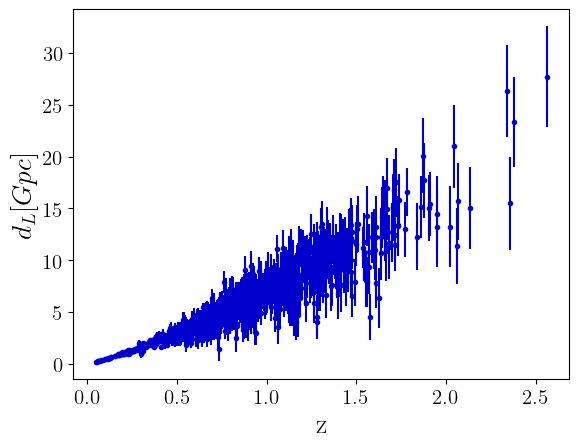

In [80]:
# plt.figure(num='ET')
data_et = data
plt.errorbar(data_et[:,0],data_et[:,3]*c/(3.08567758149137e25),data_et[:,10]*c/(3.08567758149137e25),fmt='.', color = 'mediumblue')
plt.xlabel('z', fontsize=20)
plt.ylabel('$d_L [Gpc]$',fontsize=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

In [81]:
def LISA(m,s,NoGW,Z,D):
    ## From this we can create a probability distribution function, of best fit.
    di= stats.truncnorm.pdf(Z,a=(zmin-m)/s,b=(zmax-m)/s, loc=m, scale=s)

    ## In order to use this PDF to simulate sources, we have make sure the summation equals one
    dist=di[:,0]/sum(di)

    data=[]
    def simulation(NoGW,data):

        ## We can then pick our sources of redshift weighted by the distribution 
        Z_new=choice(Z[:,0],p=dist,size=NoGW)

        ## At this point we now have NoGW simulated redshifts sources. 
        ## We then pick out the corresponding interpolated data, to be our simulation
        data=[]
        i=0
        while i<NoGW: ## Loop redefines 'data' for the sources we have picked to be events
            d=D[D[:,0]==(Z_new[i])] 
            data=np.concatenate((data,d[:,0],d[:,1],d[:,2],d[:,3],d[:,4]),axis=0)
            i=i+1

        data=np.array(data).reshape((NoGW,5)) ## This now holds our simulated data
        ## c.0=z c.1=H c.2=comov dist c.3=lum dist c.4=time 

        # data = data[np.argsort(data[:,0])] ## Sort data to make it more managable


        ##############################################################################
        ###             SECTION 2 - ADDITIONAL SIMULATED DATA (Without the need for distribution)


        ## At this point I add other simulated measurements - but these do not need
        ## a distribution, they can be random or called upon from sources in arXiv

        ## Add in additional columns to the data to provide 
        ## theta, phi: relative location of the source in the sky and psi: polarisation angle

        ##Here I have used a random generator to provide locations and polarisation
        theta=np.random.rand(data[:,1].size,1)*2*np.pi 
        phi=np.random.rand(data[:,1].size,1)*np.pi
        psi=np.random.rand(data[:,1].size,1)*np.pi

        data=np.concatenate((data,theta,phi,psi),axis=1)
        ## c.0=z c.1=H c.2=comov dist c.3=lum dist c.4=time c.5=theta c.6=phi c.7=psi 


        ## Add in additional column to the data for the angle of binary orbital angular momentum, l
        ## Again here I have used a random generator between 0-20 degrees
        l=np.random.rand(data[:,1].size,1)*20*np.pi/180

        data=np.append(data,l,axis=1)
        ## c.0=z c.1=H c.2=comov dist c.3=lum dist c.4=time c.5=theta c.6=phi c.7=psi c.8=l


        ## Add in additional column of the masses, m1 and m2, of the binary system 
        ## Then compute the total mass, M_tot, symmetric mass ratio, M_sym, and chrip mass, M_c.
        ## All masses are in units of solar mass 


        ## LISA can detect multiple different sources - we are interested in the further range sources here
        ## This means we have disregarded binary compact objects and binary intermidate massive BH

        ## First we define the predicted ratio of detection of SMBH and EMRI from arXiv: 1305.5720
        r2=100  ##MBHB (dyn/heavy)
        r3=50  ##EMRI 
        Rtot=r2+r3#+r1
        # ratio1=int(data[:,1].size*r1/Rtot)
        ratio2=int(data[:,1].size*r2/Rtot)
        ratio3=int(data[:,1].size*r3/Rtot)
        if ratio2+ratio3!=NoGW: ## This just makes sure that no.events and no. masses are the same
            ratio2=ratio2+int(NoGW-(ratio2+ratio3))


        ## SMBH mass [1e4,1e7] orbiting compact object mass for EMRI [1,1e3]
        m_1=(np.random.randint(1e4,1e7,size=(ratio2,1)))
        m_2=(np.random.randint(1e4,1e7,size=(ratio2,1)))
        m_1=np.concatenate((m_1, 

                           (np.random.randint(1e4,1e7,size=(ratio3,1)))),axis=0)

        m_2=np.concatenate((m_2, 

                           (np.random.randint(1,1e3,size=(ratio3,1)))),axis=0)

        mass=np.concatenate((m_1, m_2),axis=1)
        np.random.shuffle(mass)
        m1=mass[:,0,None]
        m2=mass[:,1,None]

        M_tot=m1+m2 ##total physical mass

        ## Observed chirp mass converted to units of seconds
        M_c=( unit* (1+data[:,0,None]) * M_tot[:,0,None]) * (((m1[:,0,None]*m2[:,0,None])/(M_tot[:,0,None]**2)) **(3/5))   
        data=np.concatenate((data,m1,m2,M_tot,M_c),axis=1)
        ## c.0=z c.1=H c.2=comov dist c.3=lum dist c.4=time c.5=theta c.6=phi c.7=psi c.8=l c.9=m1 c.10=m2 c.11=M_tot c.12=M_c



        ## Here we determine if the the GW freq produced is detectable by LISA
        ## ((c**3)/(6**(3/2)*np.pi*G*(1+data[:,0])*data[:,11]*SolM)) is the freq of the last stable orbit, 1e-4 is freq min for LISA

        data = data[
            np.logical_not(((c**3)/(6**(3/2)*np.pi*G*(1+data[:,0])*data[:,11]*SolM)) < 1e-4)]

        ##############################################################################
        ###             SECTION 3 - SIMULATING THE ERRORS

        """

        We have three errors to simulate here
        1. The error due to the lensing
        2. The error from the instruments
        3. The error from the peculiar velocity of the GW source 
        """


        ### Define a funtion to compute the signal to noise ratio, SNR, LISA's inferometer

        def SNR(phi):
            i=0
            snr=[]
            while i<=data[:,1].size-1:  ## Go through all of the simulated redshifts   
                ## The error is defined via the Fisher Matrix. This is simplified 
                ## to using the signal to noise ratio, which is determined by an integral arXiv: 1712.00952

                def Integrand(f):
                    ## As the sources we are considering have lower frequencies and can last for a long time (months)
                    ## We have to then take into account of LISAs orbitial change, first calulate the range of time
                    ## The alter the locations accordingly arXiv: 1712.00952
                    t_f=2*np.pi*((data[i,4]) - 5*((8*np.pi*f)**(-8/3))*data[i,12]**(-5/3) )/3.154e7
                    theta_s=(0.5*np.cos(theta) + np.sin(theta)*np.cos(t_f-phi)*np.sqrt(3)/2 )
                    phi_s=( t_f - np.arctan( (np.sqrt(3)*np.cos(theta) + np.sin(theta)*np.cos(t_f-phi)) 
                                                  / (2*np.sin(theta)*np.cos(t_f-phi)) )  )            

                    ## Compute the antenna beam pattern functions 
                    Fplus=np.sqrt(3)*( 0.5*(1+np.cos(theta_s)**2) * np.cos(2*phi_s)*np.cos(2*psi) - np.cos(theta_s)*np.sin(2*phi_s)*np.sin(2*psi)) /2 
                    Fcross=np.sqrt(3)*( 0.5*(1+np.cos(theta)**2) * np.cos(2*phi)*np.cos(2*psi) + np.cos(theta)*np.sin(2*phi)*np.sin(2*psi)) /2 

                    ## FT of strain/relative distance moved
                    ## We only consider here the Amplitude as the freq is in the integral below and the phase will disappear

                    Amp=np.sqrt((Fplus[i,0]*(1+np.cos(l[i,0])**2))**2 + (2*Fcross[i,0]*np.cos(l[i,0]))**2) * np.sqrt(5*np.pi/96) * np.pi**(-7/6) * data[i,12]**(5/6)/data[i,3]
                    if np.isnan(Amp)==True:
                        Amp=1j*np.sqrt(-((Fplus[i,0]*(1+np.cos(l[i,0])**2))**2 + (2*Fcross[i,0]*np.cos(l[i,0]))**2)) * np.sqrt(5*np.pi/96) * np.pi**(-7/6) * data[i,12]**(5/6)/data[i,3]
                    # print(Amp)
                    Amp=(np.absolute(Amp))**2



                    ## Next we determine the noise power spectral density PSD
                    ## arXiv: 1712.00952
                    S_ac=(9e-30 / (2*np.pi*f)**4)*(1+ (1e-4 / f))
                    S_sn=2.22e-23
                    S_om=2.65e-23


                    PSD= (20/3)*( 1+ ((f)/(0.41*(c/(2*L))))**2 )* (4*S_ac+S_sn+S_om)/L**2




                    return( ((f**(-7/3)) * Amp / PSD))
                ## Here we need to determine what is the max freq LISA can observe from the source
                f_LSO=((c**3)/(6**(3/2)*np.pi*G*(1+data[i,0])*data[i,11]*SolM))
                f_lower=1e-4
                f_up=c*2*np.pi/L
                if f_LSO<f_up:
                    f_upper=f_LSO
                else: f_upper=f_up


                I=4*integrate.quad(Integrand,f_lower,f_upper,limit=150)


                snr.append((I))
                i=i+1  ## Close the while loop and start on the next simulated redshift

            snr=array(snr) ## Create an array of the SNR^2 for each simulated redshift with the added in integrate error 
            snr=(snr[:,0,None])-snr[:,1,None]
            return snr
        ##############################################################################

        ## At this point we are now ready to use our defined SNR function to produce LISA error
        ## We can then produce the SNR for each inferometer
        k=1
        s2n1=s2n2=[]
        while k<=2:
            if k==1:
                s2n1=(SNR(phi))
            else:
                s2n2=(SNR(phi-0.25*np.pi))
            k=k+1
        ## Determine the average of the SNR via squares
        s2n=np.sqrt((s2n1) + s2n2 )
        ## Add the SNR to the data, this allows us to remove any signals, with corresponding data, 
        ## that fall beneth the allowed minimum of 8
        data=np.append(data,s2n,axis=1)
        ## c.0=z c.1=H c.2=comov dist c.3=lum dist c.4=time c.5=theta c.6=phi c.7=psi c.8=l c.9=m1 c.10=m2 c.11=M_tot c.12=M_c c.13=SNR

        ## Remove events that have SNR less than 8
        data = data[
            np.logical_not(data[:,13] < 8)]
        return data

    data=simulation(NoGW,data) ## Pull the array form the function
    ## The loop here makes sure that we at least obtain NoGW sources specified
    while data[:,0].size<NoGW:
        print(data[:,0].size)
        data=np.append(data,simulation(NoGW,data),axis=0)

    ## Define the errors due to lensing, peculiar velocity, instrumental 

    lens_error=0.5*data[:,3]*0.066*((1-(1+data[:,0])**(-0.25))/0.25)**1.8
    pec_error=data[:,3] * (1+ ((1+ data[:,0])/(data[:,1]*data[:,3])) ) * 500000/c
    LISA_error=2*data[:,3]/data[:,13]

    ## Then determine the average error via squared 
    sigma_dl=np.sqrt(LISA_error**2 + lens_error**2 + pec_error**2).reshape(-1,1)
    data=np.append(data,sigma_dl,axis=1)
    ## c.0=z c.1=H c.2=comov dist c.3=lum dist c.4=time c.5=theta c.6=phi c.7=psi c.8=l c.9=m1 c.10=m2 c.11=M_tot c.12=M_c c.13=SNR c.14=sigma_dl



    ## We then shift the luminosity points given by a guassian distribution
    ## This is done in bins

    I=0
    lumdist = []
    while I<len(sigma_dl):
        lum_b = data[:,3][I] #Create temp bin for guassian curve to be looped over
        sigma_b = data[:,14][I]
        # Determine the guassian, and populate with new guassian shifted data
        mu = lum_b
        std = sigma_b
        lum = np.random.normal(mu,std) 
        lumdist = np.append(lumdist,lum)
        I += 1
    # Replace data
    data[:,3] = lumdist[:]




    if data[:,0].size>NoGW: ## Gives NoGW data points 
        data=data[(data[:,0].size-NoGW):]
    return data

In [82]:
L=2e9
zmin=0.1
zmax=12


z_step=2000  ##Higher steps, means more accurate simulations, but slower code 2000 works well 

## Pull the data from the output of class code:
z=data_orin[:,0] ## redshift
t=data_orin[:,1] ##proper time in terms of Gyrs
t=(data_orin[-1,1]-t)*3.154e16 ## time from now
d_l=data_orin[:,6] ## luminosity distance in Mpc
d_l=d_l*(3.08567758149137e22)/c       ##convert to seconds [Mpc]/[c]
d_c=data_orin[:,5] ## comoving distance 
d_c=d_c*(3.08567758149137e22)/c       ##convert to seconds [Mpc]/[c]
H=data_orin[:,3]  ## hubble constant
H=H*c/(3.08567758149137e22)           ##convert 1/s        [c]/[Mpc]


## We then interpolate the data we have picked as the implicit funtion is unkown
fH=interpolate.interp1d(z,H)
fd_c=interpolate.interp1d(z,d_c)
fd_l=interpolate.interp1d(z,d_l)
ft=interpolate.interp1d(z,t)


## We can then chose the redshift range we are interested in
## from this we create new data from the interpolation in the redshift range
Z=np.linspace(zmax,zmin,z_step).reshape(-1,1)
#Z=np.random.uniform(zmin,zmax,z_step).reshape(-1,1)

H_new=fH(Z)
d_c_new=fd_c(Z)
d_l_new=fd_l(Z)
t_new=ft(Z)

u=Z
v=d_l_new

## Create a temporary array to hold the new interpolated data
D=[]
D=np.concatenate((Z, H_new, d_c_new, d_l_new, t_new),axis=1)

/var/folders/pn/n5lnv52d3jvdczd1hn6n94sh0000gn/T/ipykernel_12949/2251187525.py:173: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I=4*integrate.quad(Integrand,f_lower,f_upper,limit=150)
/var/folders/pn/n5lnv52d3jvdczd1hn6n94sh0000gn/T/ipykernel_12949/2251187525.py:173: IntegrationWarning: The maximum number of subdivisions (150) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  I=4*integrate.quad(Integrand,f_lower,f_upper,limit=150)


22
43


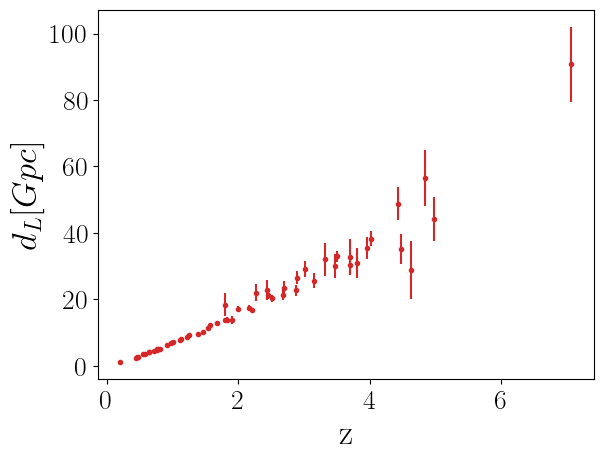

In [83]:
m=np.mean([2.012, 7.002, 8.169, 5.412, 3.300, 1.590, 0.624, 0.141, 0.000])
s=np.std([2.012, 7.002, 8.169, 5.412, 3.300, 1.590, 0.624, 0.141, 0.000])
NoGW = 56
data_p3 = LISA(m,s,NoGW,Z,D)

plt.errorbar(data_p3[:,0],data_p3[:,3]*c/(3.08567758149137e25),data_p3[:,14]*c/(3.08567758149137e25),fmt='.', color = 'tab:red')
plt.xlabel('z',fontsize=25)
plt.ylabel('$d_L [Gpc]$',fontsize=25)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

/var/folders/pn/n5lnv52d3jvdczd1hn6n94sh0000gn/T/ipykernel_12949/2251187525.py:173: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I=4*integrate.quad(Integrand,f_lower,f_upper,limit=150)
/var/folders/pn/n5lnv52d3jvdczd1hn6n94sh0000gn/T/ipykernel_12949/2251187525.py:173: IntegrationWarning: The maximum number of subdivisions (150) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  I=4*integrate.quad(Integrand,f_lower,f_upper,limit=150)


21
42


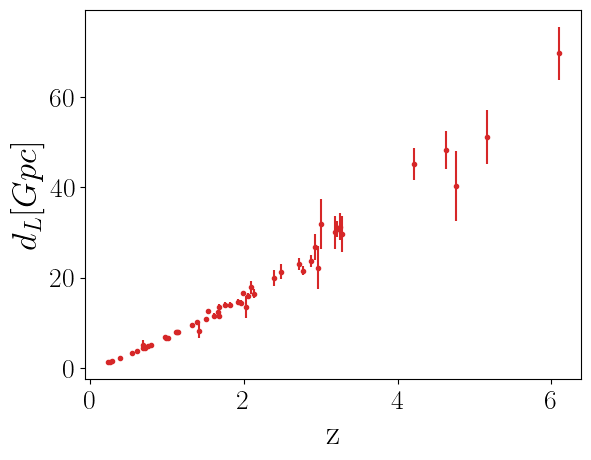

In [84]:
m=np.mean([0.926, 4.085, 5.976, 5.131, 4.769, 2.656, 1.710, 0.644, 0.362])
s=np.std([0.926, 4.085, 5.976, 5.131, 4.769, 2.656, 1.710, 0.644, 0.362])
NoGW = 52
data_de = LISA(m,s,NoGW,Z,D)

plt.errorbar(data_de[:,0],data_de[:,3]*c/(3.08567758149137e25),data_de[:,14]*c/(3.08567758149137e25),fmt='.', color = 'tab:red')
plt.xlabel('z',fontsize=25)
plt.ylabel('$d_L [Gpc]$',fontsize=25)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

/var/folders/pn/n5lnv52d3jvdczd1hn6n94sh0000gn/T/ipykernel_12949/2251187525.py:173: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I=4*integrate.quad(Integrand,f_lower,f_upper,limit=150)
/var/folders/pn/n5lnv52d3jvdczd1hn6n94sh0000gn/T/ipykernel_12949/2251187525.py:173: IntegrationWarning: The maximum number of subdivisions (150) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  I=4*integrate.quad(Integrand,f_lower,f_upper,limit=150)


13
35
55
73


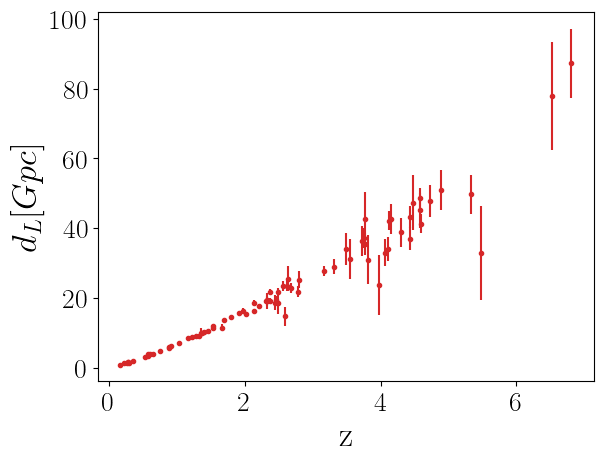

In [85]:
m=np.mean([3.682, 10.28, 9.316, 7.646, 4.909, 2.817, 1.187, 0.362, 0.161])
s=np.std([3.682, 10.28, 9.316, 7.646, 4.909, 2.817, 1.187, 0.362, 0.161])
NoGW = 80
data_node = LISA(m,s,NoGW,Z,D)

plt.errorbar(data_node[:,0],data_node[:,3]*c/(3.08567758149137e25),data_node[:,14]*c/(3.08567758149137e25),fmt='.', color = 'tab:red')
plt.xlabel('z',fontsize=25)
plt.ylabel('$d_L [Gpc]$',fontsize=25)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

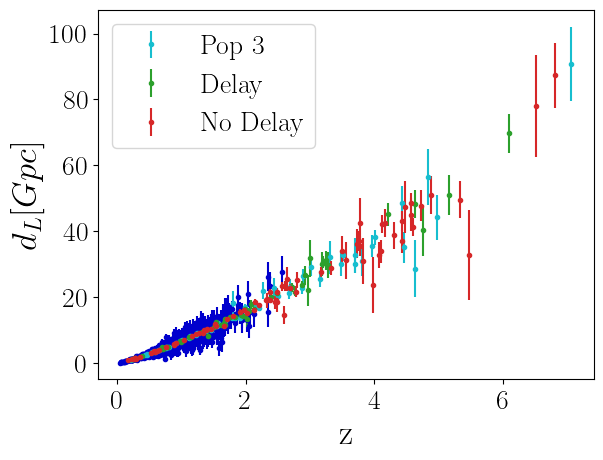

In [86]:
plt.errorbar(data_et[:,0],data_et[:,3]*c/(3.08567758149137e25),data_et[:,10]*c/(3.08567758149137e25),fmt='.', color = 'mediumblue')
plt.errorbar(data_p3[:,0],data_p3[:,3]*c/(3.08567758149137e25),data_p3[:,14]*c/(3.08567758149137e25),fmt='.', color = 'tab:cyan', label = 'Pop 3')
plt.errorbar(data_de[:,0],data_de[:,3]*c/(3.08567758149137e25),data_de[:,14]*c/(3.08567758149137e25),fmt='.', color = 'tab:green', label = 'Delay')
plt.errorbar(data_node[:,0],data_node[:,3]*c/(3.08567758149137e25),data_node[:,14]*c/(3.08567758149137e25),fmt='.', color = 'tab:red', label = 'No Delay')
plt.xlabel('z',fontsize=25)
plt.ylabel('$d_L [Gpc]$',fontsize=25)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.legend(loc = 'upper left', fontsize=20)